# Binary star evolution and binary black holes
A Binary Black Hole (BBH) can originate from the evolution of a massive binary star. If the binary is tight enough, it will evolve through several complex physical processes: the two stars can exchange mass either via **Stable Mass Transfer (SMT)** or via a **Common Envelope (CE)**.

Mass transfer is mainly driven by Roche-lobe filling, as this process is usually more efficient than wind accretion. The Roche lobe of a star in a binary system is a teardrop-shaped equipotential surface surrounding the star. Mass transfer occurs when a star overfills its Roche lobe, i.e. when its radius becomes larger than the Roche lobe, and it changes:
- the mass of each star
- the final mass of the compact remnants
- orbital properties of the binary (e.g. the semi-major axis)

<div>
<img src="Roche_lobe_overflow.jpg" width="700"/>
</div>

If mass transfer becomes unstable (e.g. both stars fill Roche lobe), the two stars enter a Common Envelope phase: the binary system is embedded in a gaseous, non-corotating envelope and the two members spiral in due to the gas drag exerted by the envelope. Part of the orbital energy lost as an effect of this drag is likely converted into heating of the envelope, making it more loosely bound, and this process can lead to the ejection of the envelope.

<div>
<img src="common_envelope.png" width="700"/>
</div>

To describe a common envelope, the most common formalism is the $\alpha$ formalism, where $\alpha$ is a dimensionless parameter that measures the fraction of the removed orbital energy that is transferred to the envelope, so the efficiency with which the CE is expelled. A large alpha means that the envelope is easily ejected, while a small alpha means that it takes a lot of energy to be expelled.

The simulated system can have an apparently unphysical value of $\alpha>1$, due to the fact that this simple formalism poorly describes the physics of CE, so in a full discussion the orbital energy is only one of the energy sources that partecipate in the envelope ejection.


## Goal of the project
Understand the differences between binary black hole mergers whose progenitors evolved via common envelope and binary black hole mergers whose progenitors evolved via stable mass transfer, by looking at a set of simulated binary black holes.

## Datasets 

Datasets are stored on Google Drive at this [link](https://drive.google.com/drive/folders/1RZGrL6RrKYKaPu0VJ7BQDXptb7B_QOLg). The tar file stable_MT_vs_CE.tgz contains 4 folders (A0.5, A1, A3 and A5). Each of them corresponds to the outputs of a set of simulations of binary black holes, which differ only by one parameter: the value of the parameter $\alpha$ ($\alpha$=0.5,1,3,5) associated with the efficiency of common envelope.

Inside each folder, there are 12 files, named MTCE_BBHs_*.txt, where * is a number ranging from 0.0002 to 0.02 and represents the stellar metallicity at which the black holes where produced in the simulations.

Each row contains the properties of one simulated binary black hole. The most important columns (properties) for this analysis are:
- Column 1: initial mass (ZAMS mass) of the primary member of the binary system in Msun
- Column 2: initial mass (ZAMS mass) of the secondary member of the binary system in Msun
- Column 3: mass of the black hole that forms from the primary member (Msun)
- Column 4: mass of the black hole that forms from the secondary member (Msun)
- Column 6: delay time, i.e. time elapsed from the formation of the binary system to the merger of the two black holes (in Myr)
- Column 7: semi-major axis of the binary system at the formation of the second-born black hole (in solar radii, Rsun = 6.95e10 cm)
- Column 8: orbital eccentricity of the binary system at the formation of the second-born black hole
- **Column 21: Boolean variable indicating whether the binary system undergoes a common envelope (True). If column 21 is False, the binary goes via stable mass transfer instead of a common envelope.**

We then added 4 extra columns to the dataframe: 
- Metallicity
- Alpha ($\alpha$)
- Column Extra 1: inital mass ratio (ZAMS mass of the primary / ZAMS mass of the secondary)
- Column Extra 2: mass ratio of the black holes (mass of the BH that forms from the primary / mass of the BH that forms from the secondary)


## Creation of the dataframe

In [2]:
import pandas as pd
import numpy as np
import string
import glob
import os
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy import linalg as la
from IPython.display import display
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

In [3]:
# personalized computer settings

hname = os.getlogin()
path = ''

if hname=='paolozinesi': path = '/Users/paolozinesi/Desktop/Magistrale/a.a.2021_2022/Project_LCP_A/stable_MT_vs_CE/'
if hname=='tommaso': path = "/Users/tommaso/Desktop/MagistraleI/TheFormationOfBinaryBlackHoles_data/lab_data/stable_MT_vs_CE/"
if hname=='Nicola': path = "/Users/Nicola/data/TheFormationOfBinaryBlackHoles_data/stable_MT_vs_CE/"
if hname=='ilazza': path = "/home/ilazza/Documenti/UNIPD/TheFormationOfBinaryBlackHoles/stable_MT_vs_CE/"

In [4]:
alpha_values = [0.5, 1, 3, 5]
met_values = [0.02, 0.002, 0.0002, 0.004, 0.0004, 0.006, 0.008, 0.012, 0.0012, 0.016, 0.0016]
columns=['col.0:ID','col.1:m1ZAMS/Msun', 'col.2:m2ZAMS/Msun', 'col.3:m1rem/Msun','col.4:m2rem/Msun',  'col.6:delay_time/Myr', 'col.7:sma/Rsun', 'col.8:ecc', 'col.21:CE']
frame = pd.DataFrame(data=None, columns=columns)

for alpha in alpha_values:
    for met in met_values:
        for name in glob.glob(path+f'A{alpha}/MTCE_BBHs_{met}*'):
            df = pd.read_csv(name, skiprows=2, header=0, sep=' ')
            df = df.loc[:,columns]
            met_array = np.ones((df.shape[0], 1))*met
            alpha_array = np.ones((df.shape[0],1))*alpha
            df['metallicity'] = met_array
            df['alpha'] = alpha_array
            
            frame = pd.concat([frame, df], axis=0, ignore_index=True)
            
frame['colExt1:ratio_m1_m2_ZAMS'] = frame['col.1:m1ZAMS/Msun']/frame['col.2:m2ZAMS/Msun']
frame['colExt2:ratio_m1_m2_rem'] = frame['col.3:m1rem/Msun']/frame['col.4:m2rem/Msun']


In [5]:
frame.head()

,col.0:ID,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha,colExt1:ratio_m1_m2_ZAMS,colExt2:ratio_m1_m2_rem
0,0_6942,50.9151,50.8356,4.8001,4.7478,2233.6292,7.9524,0.273150,True,0.02,0.5,1.001564,1.011016
1,0_80347,57.0253,56.9464,5.5849,5.5325,1076.5703,9.0222,0.508320,True,0.02,0.5,1.001386,1.009471
2,0_158611,91.0594,90.7083,8.3787,8.2624,6810.4365,14.9810,0.072798,True,0.02,0.5,1.003871,1.014076
3,0_211410,117.9396,57.6917,19.3984,11.2422,7905.6343,11229.0000,0.999640,False,0.02,0.5,2.044308,1.725499
4,0_213101,40.2965,40.2439,3.1045,3.0769,8703.5479,13.7630,0.705290,True,0.02,0.5,1.001307,1.008970


In [6]:
#Creating the a dataframe with common envelopes and one with mass transfer
frame_true = frame[(frame['col.21:CE'] == True)] 
frame_true = frame_true.reset_index(drop=True)
frame_false = frame[(frame['col.21:CE'] == False)] 
frame_false = frame_false.reset_index(drop=True)

In [7]:
frame_true.head()



,col.0:ID,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha,colExt1:ratio_m1_m2_ZAMS,colExt2:ratio_m1_m2_rem
0,0_6942,50.9151,50.8356,4.8001,4.7478,2233.6292,7.9524,0.273150,True,0.02,0.5,1.001564,1.011016
1,0_80347,57.0253,56.9464,5.5849,5.5325,1076.5703,9.0222,0.508320,True,0.02,0.5,1.001386,1.009471
2,0_158611,91.0594,90.7083,8.3787,8.2624,6810.4365,14.9810,0.072798,True,0.02,0.5,1.003871,1.014076
3,0_213101,40.2965,40.2439,3.1045,3.0769,8703.5479,13.7630,0.705290,True,0.02,0.5,1.001307,1.008970
4,0_261642,62.6781,58.8130,7.5024,5.9658,2895.4182,10.4610,0.163210,True,0.02,0.5,1.065718,1.257568


In [8]:
frame_false.head()

,col.0:ID,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha,colExt1:ratio_m1_m2_ZAMS,colExt2:ratio_m1_m2_rem
0,0_211410,117.9396,57.6917,19.3984,11.2422,7905.6343,11229.000,0.999640,False,0.020,0.5,2.044308,1.725499
1,1_3370919,76.2366,38.3205,10.0905,8.1532,5914.8696,5378.200,0.999510,False,0.020,0.5,1.989447,1.237612
2,1_3601930,123.0264,39.9761,18.0234,7.6028,9398.3252,3408.700,0.998740,False,0.020,0.5,3.077499,2.370627
3,3_2982857,132.6673,30.7234,20.7397,5.6742,3331.2690,3755.500,0.999260,False,0.020,0.5,4.318119,3.655088
4,0_526,75.1587,33.6683,26.1035,25.6875,12982.4980,41.214,0.009654,False,0.002,0.5,2.232328,1.016195


In [9]:
#frame_graph = frame.drop(columns=['col.0:ID'], axis=1)
#sns.pairplot(frame, hue = 'col.21:CE', palette='Set2')

In [10]:
#frame_graph.head()

In [11]:



#frame_graph = frame.drop(columns=['col.0:ID', 'metallicity', 'alpha'], axis=1)
#sns.pairplot(frame_graph, hue = 'col.21:CE', palette='Set2')
                    

## ML algorithms

In order to extract the most important features from our data, we run some Machine Learning (ML) algorithms on the dataset. We focused only on the columns showed in the "Dataset" paragraph above, plus metallicity, alpha and the two extra columns containing the ratio of the masses.

In particular, we compared **Random Forest (RF)** and **Support Vector Machines (SVM)** algorithms in the classification of the process behind the formation of the BBH progenitors. We analyzed at first a small set of data with equal number of CE and SMT samples, eventually performing a Principal Component Analysis (PCA) to reduce the dimensionality of the dataset with little loss of information. However, even within this small dataset the most important features show up very clearly. Then we run the same ML algorithms in the whole dataset, obtaining similar results but with a more accurate estimation of the algorithm performances on the test data. Note that the full dataset has a different number of CE and SMT samples, while the limited dataset contains the same number of CE and SMT samples by construction.

### Limited data

In [12]:
# create training and test set
m_train = 20000
m_test = 1000

frame_sample = pd.concat([frame_true.sample(n=int(0.5*(m_train+m_test))),
                          frame_false.sample(n=int(0.5*(m_train+m_test)))], ignore_index=True)

frame_sample = frame_sample.sample(frac=1, ignore_index=True)
frame_train = frame_sample.iloc[:m_train]
frame_test = frame_sample.iloc[-m_test:]

# separate dataframes
lbl = {False:'SMT', True:'CE'}
X_train = frame_train.drop(labels=["col.0:ID","col.21:CE"], axis=1)
Y_train = frame_train["col.21:CE"].apply(lambda x: lbl[x])
X_test = frame_test.drop(labels=["col.0:ID","col.21:CE"], axis=1)
Y_test = frame_test["col.21:CE"].apply(lambda x: lbl[x])

### PCA

In [13]:
# DATA NORMALIZATION
# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_train)

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
pd.set_option("chop_threshold", 1e-08)

X_train_ = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
df_tmp = pd.DataFrame(np.around(pd.concat([X_train_.mean(axis=0), X_train_.std(axis=0)], axis=1), 3))
df_tmp.columns = ['mean','std']
print ("\nMean and std of the training input data:", )
display(df_tmp)

X_test_ = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns) # use the same transformation on test data
# df_tmp = pd.DataFrame(np.around(pd.concat([X_test_.mean(axis=0), X_test_.std(axis=0)], axis=1), 3))
# df_tmp.columns = ['mean','std']
# print ("\nMean and std of the test input data:", )
# display(df_tmp)

# PCA
data_PCA = X_train_.values.T
# eigenvectors and eigenvalues using SVD
U, spectrum, Vt = la.svd(data_PCA)
V = U                          # eigenvectors matrix
l = spectrum**2/(m_train-1)    # eigenvalues
np.set_printoptions(precision=3)
print('\nEigenvalues: \n', l)
# print('Eigenvectors:\n', V_svd)

ncomp = 8
variability_PC = np.sum(l[:ncomp])/np.sum(l)
print('\nPercent of the total variability explained by the %.0f principal components: %.5f' %(ncomp, variability_PC))


Mean and std of the training input data:


,mean,std
col.1:m1ZAMS/Msun,0.0,1.0
col.2:m2ZAMS/Msun,0.0,1.0
col.3:m1rem/Msun,0.0,1.0
col.4:m2rem/Msun,0.0,1.0
col.6:delay_time/Myr,0.0,1.0
col.7:sma/Rsun,0.0,1.0
col.8:ecc,0.0,1.0
metallicity,0.0,1.0
alpha,0.0,1.0
colExt1:ratio_m1_m2_ZAMS,0.0,1.0



Eigenvalues: 
 [3.872 1.872 1.187 1.107 0.899 0.827 0.662 0.463 0.062 0.039 0.009]

Percent of the total variability explained by the 8 principal components: 0.98997


,0,1,2,3,4,5,6,7,col.21:CE
0,-1.440739,-1.08194,-1.22521,0.250912,-0.645924,0.137656,0.200571,0.074355,CE
1,-4.133627,0.830352,0.765157,-0.940151,-1.178259,-0.506358,-1.77101,-0.76343,SMT
2,-3.123862,0.002725,-0.117445,-0.644019,-0.897394,-0.606931,1.02983,0.079455,SMT
3,-1.289957,-0.105368,0.772258,-0.284783,0.102841,-0.128716,1.66313,0.326025,SMT
4,0.653045,-0.823892,-1.443227,0.67284,-0.596303,0.400092,0.24368,0.465271,CE


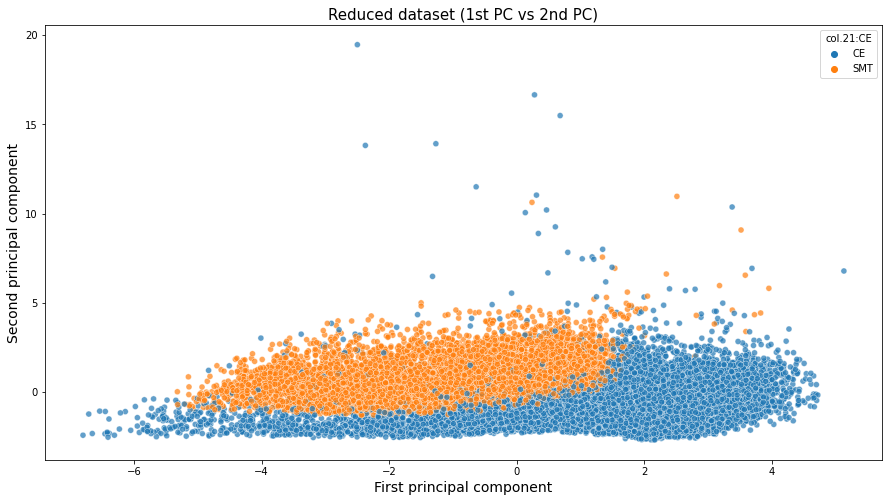

In [19]:
# Data in the PCA basis
data_ = np.dot(V.T, data_PCA)

# Reduce the dimensionality of the dataset 
data_reduced = data_[:ncomp,:] 

X_train_PCA = pd.DataFrame(data_reduced.T)
X_test_PCA = pd.DataFrame(np.dot(V.T, X_test_.T)[:ncomp,:].T)
# print(X_train_PCA.shape)
# print(X_test_PCA.shape)

df = pd.DataFrame(np.column_stack((X_train_PCA, Y_train)))
df.rename(columns = {ncomp:'col.21:CE'}, inplace=True)
display(df.head())

plt.figure(figsize=(15, 8))
sns.scatterplot(x=0, y=1, hue='col.21:CE', data=df, alpha=0.7)
plt.xlabel('First principal component', fontsize=14)
plt.ylabel('Second principal component', fontsize=14)
plt.title('Reduced dataset (1st PC vs 2nd PC)', fontsize=15)
plt.show()

The PCA shows us clearly that there might exist some (combination of) features that allows us to separate the two classes of events. But if, on one hand, this analysis reduces the number of features, on the other hand information about the physical process are lost. So, with PCA is more difficult to extract the physical meaning on the classification criteria ....

### Random Forest: no smoothing, no normalization of data

In [14]:
RF_clf = RandomForestClassifier(max_depth=None)
RF_clf.fit(X_train, Y_train)

train_err = 1 - RF_clf.score(X_train, Y_train)
print("Training error = %1.3f" % train_err)
test_err = 1 - RF_clf.score(X_test, Y_test)
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([RF_clf.feature_names_in_, RF_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.000
Test error = 0.006


,feature names,feature importance
9,colExt1:ratio_m1_m2_ZAMS,0.269806
10,colExt2:ratio_m1_m2_rem,0.183949
5,col.7:sma/Rsun,0.132792
2,col.3:m1rem/Msun,0.124309
0,col.1:m1ZAMS/Msun,0.097994
3,col.4:m2rem/Msun,0.055983
6,col.8:ecc,0.047404
1,col.2:m2ZAMS/Msun,0.042048
4,col.6:delay_time/Myr,0.032307
7,metallicity,0.00953


In [15]:
# Export as dot file
#export_graphviz(RF_clf.estimators_[50], out_file='RF.dot', 
#                feature_names = RF_clf.feature_names_in_,
#                class_names = RF_clf.classes_,
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

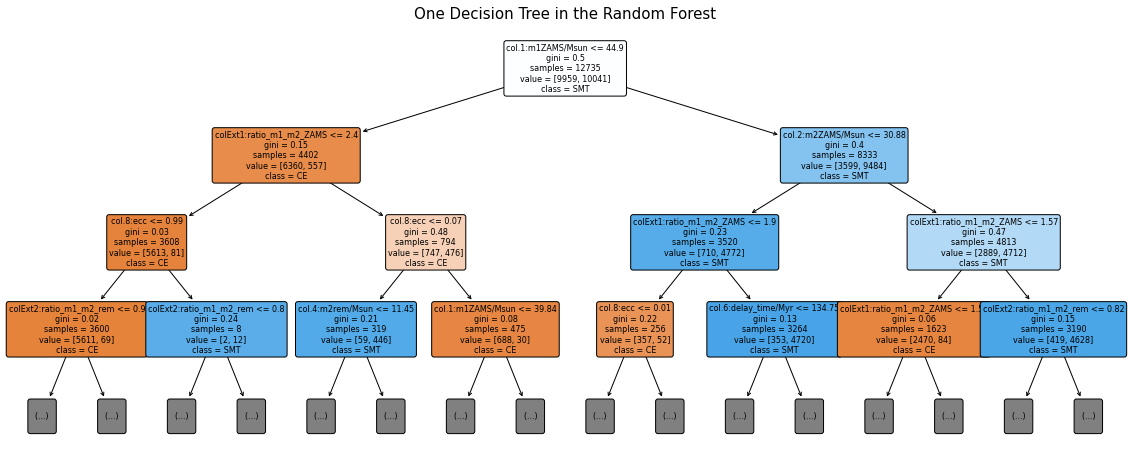

In [16]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(RF_clf.estimators_[50], max_depth=3,
                        feature_names = RF_clf.feature_names_in_,
                        class_names = RF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize=8, ax=ax)
ax.set_title('One Decision Tree in the Random Forest', fontsize=15)
plt.show()

### Random Forest: no smoothing, with normalization of data

In [17]:
normRF_clf = RandomForestClassifier(max_depth=None)
normRF_clf.fit(X_train_, Y_train)

train_err = 1 - normRF_clf.score(X_train_, Y_train)
print("Training error = %1.3f" % train_err)
test_err = 1 - normRF_clf.score(X_test_, Y_test)
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([normRF_clf.feature_names_in_, normRF_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.000
Test error = 0.006


,feature names,feature importance
9,colExt1:ratio_m1_m2_ZAMS,0.264037
10,colExt2:ratio_m1_m2_rem,0.180366
5,col.7:sma/Rsun,0.145326
0,col.1:m1ZAMS/Msun,0.121434
2,col.3:m1rem/Msun,0.108267
3,col.4:m2rem/Msun,0.053933
6,col.8:ecc,0.040419
1,col.2:m2ZAMS/Msun,0.0385
4,col.6:delay_time/Myr,0.033326
7,metallicity,0.010378


In [18]:
# Export as dot file
#export_graphviz(normRF_clf.estimators_[50], out_file='normRF.dot', 
#                feature_names = normRF_clf.feature_names_in_,
#                class_names = str(normRF_clf.classes_),
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

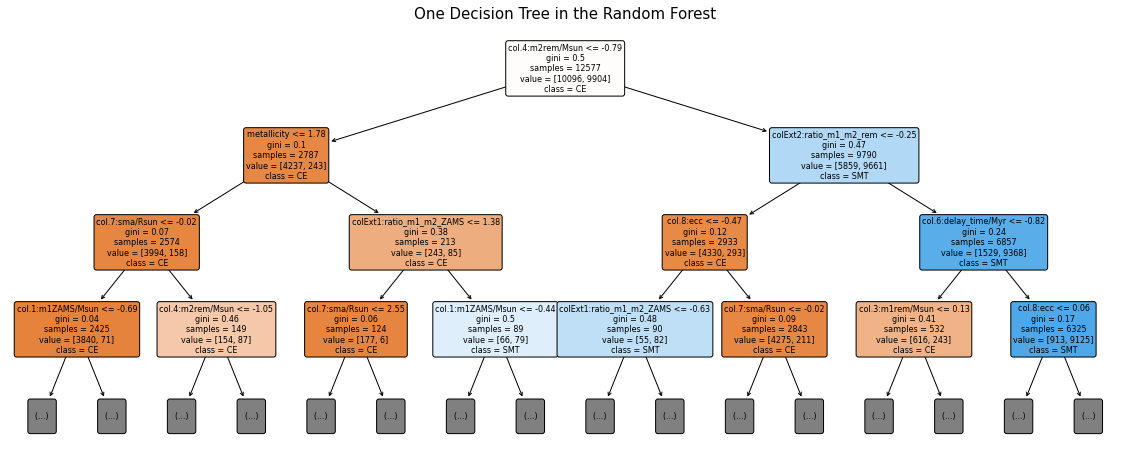

In [19]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(normRF_clf.estimators_[50], max_depth=3,
                        feature_names = normRF_clf.feature_names_in_,
                        class_names = normRF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize=8, ax=ax);
ax.set_title('One Decision Tree in the Random Forest', fontsize=15)
plt.show()

### Random Forest: with smoothing, with normalization of data

In [20]:
# cross validation
parameters = {'max_depth':[3,5,7], 'min_samples_leaf':[1e-05,1e-04,1e-03,1e-02]}
cvres = GridSearchCV(RandomForestClassifier(), parameters)
cvres.fit(X_train_, Y_train)

print("Best parameters: ", cvres.best_params_)
display(pd.DataFrame.from_dict(cvres.cv_results_))
smooth_normRF_clf = cvres.best_estimator_

Best parameters:  {'max_depth': 7, 'min_samples_leaf': 0.0001}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.660104,0.160484,0.047729,0.018051,3,0.00001,"{'max_depth': 3, 'min_samples_leaf': 1e-05}",0.96650,0.96825,0.96350,0.96750,0.96025,0.96520,0.002956,11
1,1.969960,0.336166,0.067132,0.029151,3,0.0001,"{'max_depth': 3, 'min_samples_leaf': 0.0001}",0.96700,0.96725,0.96750,0.96700,0.95900,0.96555,0.003280,10
2,1.580171,0.198534,0.053798,0.031307,3,0.001,"{'max_depth': 3, 'min_samples_leaf': 0.001}",0.96750,0.96925,0.96450,0.96700,0.96525,0.96670,0.001684,9
3,1.828865,0.276543,0.055297,0.033093,3,0.01,"{'max_depth': 3, 'min_samples_leaf': 0.01}",0.96525,0.96200,0.96625,0.96750,0.96300,0.96480,0.002033,12
4,2.017855,0.227528,0.040097,0.000579,5,0.00001,"{'max_depth': 5, 'min_samples_leaf': 1e-05}",0.97725,0.97675,0.97775,0.97675,0.97350,0.97640,0.001497,4
5,1.908627,0.012251,0.040701,0.000251,5,0.0001,"{'max_depth': 5, 'min_samples_leaf': 0.0001}",0.97600,0.97725,0.97850,0.97550,0.97150,0.97575,0.002366,6
6,2.153062,0.232830,0.046340,0.010599,5,0.001,"{'max_depth': 5, 'min_samples_leaf': 0.001}",0.97675,0.97600,0.97725,0.97700,0.97350,0.97610,0.001366,5
7,1.918302,0.264860,0.041077,0.000358,5,0.01,"{'max_depth': 5, 'min_samples_leaf': 0.01}",0.96875,0.97125,0.97050,0.97225,0.96550,0.96965,0.002370,8
8,2.686439,0.204531,0.046791,0.004202,7,0.00001,"{'max_depth': 7, 'min_samples_leaf': 1e-05}",0.98325,0.98250,0.98425,0.98325,0.98025,0.98270,0.001345,2
9,2.734797,0.403877,0.045352,0.003303,7,0.0001,"{'max_depth': 7, 'min_samples_leaf': 0.0001}",0.98375,0.98175,0.98525,0.98350,0.98100,0.98305,0.001512,1


In [21]:
train_err = 1 - smooth_normRF_clf.score(X_train_, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - smooth_normRF_clf.score(X_test_, Y_test)
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([smooth_normRF_clf.feature_names_in_, smooth_normRF_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.015
Test error = 0.018


,feature names,feature importance
10,colExt2:ratio_m1_m2_rem,0.25681
9,colExt1:ratio_m1_m2_ZAMS,0.216846
5,col.7:sma/Rsun,0.13087
2,col.3:m1rem/Msun,0.121419
0,col.1:m1ZAMS/Msun,0.104628
6,col.8:ecc,0.053048
3,col.4:m2rem/Msun,0.044023
1,col.2:m2ZAMS/Msun,0.038409
4,col.6:delay_time/Myr,0.026504
7,metallicity,0.004307


In [22]:
# Export as dot file
#export_graphviz(smooth_normRF_clf.estimators_[50], out_file='smooth_normRF.dot', 
#                feature_names = smooth_normRF_clf.feature_names_in_,
#                class_names = str(smooth_normRF_clf.classes_),
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

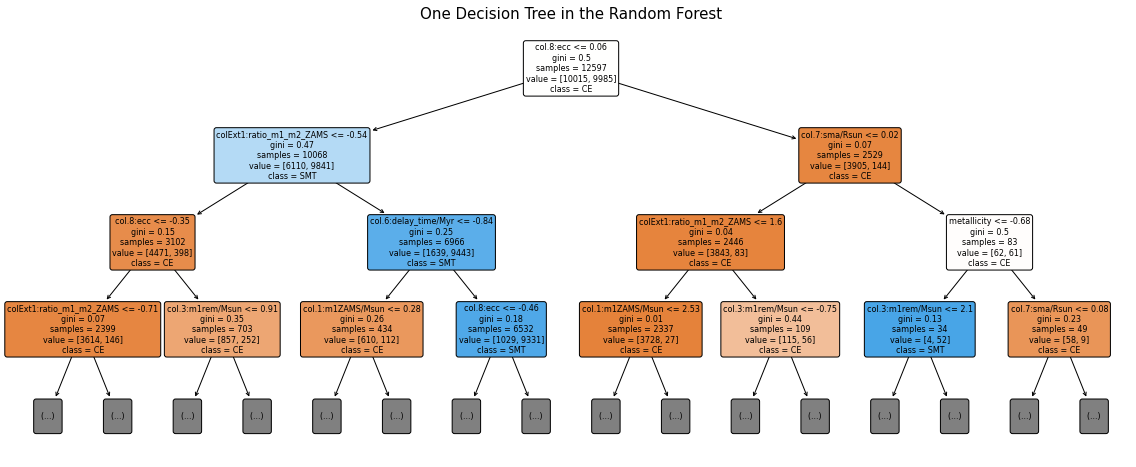

In [23]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(smooth_normRF_clf.estimators_[50], max_depth=3,
                        feature_names = smooth_normRF_clf.feature_names_in_,
                        class_names = smooth_normRF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize=8, ax=ax)

ax.set_title('One Decision Tree in the Random Forest', fontsize=15)
plt.show()

### Random Forest: with smoothing, with PCA

In [24]:
# cross validation
parameters = {'max_depth':[3,5,7], 'min_samples_leaf':[1e-05,1e-04,1e-03,1e-02]}

cvres = GridSearchCV(RandomForestClassifier(), parameters)
cvres.fit(X_train_PCA, Y_train)
display(pd.DataFrame.from_dict(cvres.cv_results_))
smooth_PCA_RF_clf = cvres.best_estimator_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.822960,0.376538,0.061056,0.019630,3,0.00001,"{'max_depth': 3, 'min_samples_leaf': 1e-05}",0.93125,0.93350,0.93675,0.93475,0.93425,0.93410,0.001786,12
1,1.506266,0.349775,0.068830,0.033576,3,0.0001,"{'max_depth': 3, 'min_samples_leaf': 0.0001}",0.93775,0.94275,0.93775,0.94325,0.93200,0.93870,0.004094,9
2,1.647919,0.187576,0.056701,0.028606,3,0.001,"{'max_depth': 3, 'min_samples_leaf': 0.001}",0.91900,0.93550,0.94625,0.94050,0.94100,0.93645,0.009365,11
3,1.395284,0.135086,0.068492,0.035732,3,0.01,"{'max_depth': 3, 'min_samples_leaf': 0.01}",0.92725,0.94450,0.93675,0.93975,0.93750,0.93715,0.005640,10
4,2.165764,0.181941,0.045136,0.002749,5,0.00001,"{'max_depth': 5, 'min_samples_leaf': 1e-05}",0.96275,0.96475,0.96925,0.96150,0.96300,0.96425,0.002706,5
5,1.919470,0.126047,0.061699,0.036303,5,0.0001,"{'max_depth': 5, 'min_samples_leaf': 0.0001}",0.96325,0.96450,0.96850,0.96250,0.96300,0.96435,0.002177,4
6,1.847995,0.409623,0.044093,0.002342,5,0.001,"{'max_depth': 5, 'min_samples_leaf': 0.001}",0.96225,0.96425,0.96475,0.96050,0.96225,0.96280,0.001536,6
7,1.776042,0.234545,0.052415,0.006332,5,0.01,"{'max_depth': 5, 'min_samples_leaf': 0.01}",0.95700,0.96300,0.96275,0.95750,0.96025,0.96010,0.002523,8
8,2.559385,0.253297,0.053691,0.009459,7,0.00001,"{'max_depth': 7, 'min_samples_leaf': 1e-05}",0.97325,0.97650,0.97900,0.97500,0.97450,0.97565,0.001972,1
9,3.141796,0.607433,0.084133,0.043258,7,0.0001,"{'max_depth': 7, 'min_samples_leaf': 0.0001}",0.97250,0.97475,0.97850,0.97325,0.97125,0.97405,0.002497,2


In [25]:
train_err = 1 - smooth_PCA_RF_clf.score(X_train_PCA, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - smooth_PCA_RF_clf.score(X_test_PCA, Y_test)
print("Test error = %1.3f" % test_err)

Training error = 0.021
Test error = 0.030


In [26]:
# Export as dot file
#export_graphviz(smooth_PCA_RF_clf.estimators_[50], out_file='smooth_PCA_RF.dot', 
#                feature_names = smooth_PCA_RF_clf.feature_names_in_,
#                class_names = str(smooth_PCA_RF_clf.classes_),
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

<AxesSubplot:>

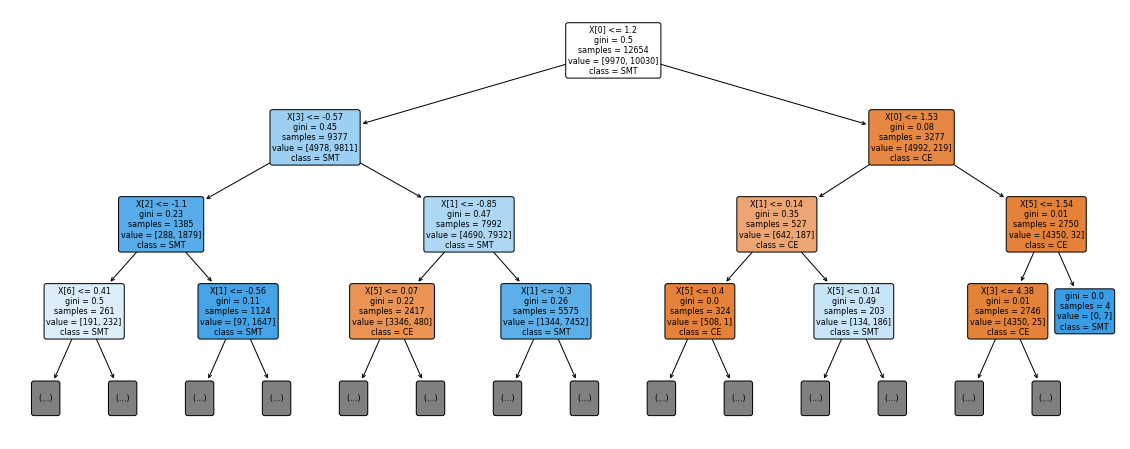

In [27]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(smooth_PCA_RF_clf.estimators_[50], max_depth=3,
                        feature_names = None,
                        class_names = smooth_PCA_RF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize=8, ax=ax)
ax

### SVM: with normalization of data

In [ ]:
SVM_clf = sklearn.svm.LinearSVC(dual=False)
SVM_clf.fit(X_train_, Y_train)

train_err = 1 - SVM_clf.score(X_train_, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - SVM_clf.score(X_test_, Y_test)
print("Test error = %1.3f" % test_err)

display(pd.DataFrame(data=np.array([SVM_clf.feature_names_in_, np.abs(SVM_clf.coef_[0])]).T,
                     columns=["feature names", "feature weights (absolute value)"]).sort_values(by="feature weights (absolute value)", ascending=False))

### Full dataset
#### !!!!! Warning: long computational time from now on

In [28]:
# fraction of data for test set
test_fract = 0.01
m_test_full = int(frame.shape[0]*test_fract)
m_train_full = frame.shape[0] - m_test_full
frame_sample_full = frame.sample(frac=1, replace=False, ignore_index=True)
frame_train_full = frame_sample_full.iloc[:-m_test_full]
frame_test_full = frame_sample_full.iloc[-m_test_full:]

# separate dataframes
lbl = {False:'SMT', True:'CE'}
X_train_full = frame_train_full.drop(labels=['col.0:ID','col.21:CE'], axis=1)
Y_train_full = frame_train_full["col.21:CE"].apply(lambda x: lbl[x])
X_test_full = frame_test_full.drop(labels=['col.0:ID','col.21:CE'], axis=1)
Y_test_full = frame_test_full["col.21:CE"].apply(lambda x: lbl[x])

### PCA on the full dataset

In [29]:
# DATA NORMALIZATION
# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_train_full)

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
pd.set_option("chop_threshold", 1e-08)

X_train_full_ = pd.DataFrame(scaler.transform(X_train_full),columns=X_train_full.columns)
print ("\nMean of the training input data:", np.around(X_train_full_.mean(axis=0), 4))
print ("\nStd of the training input data:", np.around(X_train_full_.std(axis=0), 4))

X_test_full_ = pd.DataFrame(scaler.transform(X_test_full),columns=X_test_full.columns) # use the same transformation on test data
# print ("\nMean of the test input data:\n", X_test_full_.mean(axis=0))
# print ("\nStd of the test input data:\n", X_test_full_.std(axis=0))

# PCA
data_PCA = X_train_full_.cov()

# eigenvectors and eigenvalues using covariance matrix
l, V = la.eig(data_PCA)

# sort to have the eigenvalues in descending order
idx = l.argsort()[::-1]
l = np.real_if_close(l[idx])
V = V[:, idx]

np.set_printoptions(precision=3)
print('\nEigenvalues: \n', l)
#print('Eigenvectors:\n', V)

ncomp = 8
variability_PC = np.sum(l[:ncomp])/np.sum(l)
print('\nPercent of the total variability explained by the %.0f principal components: %.5f' %(ncomp, variability_PC))


Mean of the training input data: col.1:m1ZAMS/Msun           0.0
col.2:m2ZAMS/Msun           0.0
col.3:m1rem/Msun            0.0
col.4:m2rem/Msun            0.0
col.6:delay_time/Myr        0.0
col.7:sma/Rsun              0.0
col.8:ecc                   0.0
metallicity                 0.0
alpha                       0.0
colExt1:ratio_m1_m2_ZAMS    0.0
colExt2:ratio_m1_m2_rem     0.0
dtype: float64

Std of the training input data: col.1:m1ZAMS/Msun           1.0
col.2:m2ZAMS/Msun           1.0
col.3:m1rem/Msun            1.0
col.4:m2rem/Msun            1.0
col.6:delay_time/Myr        1.0
col.7:sma/Rsun              1.0
col.8:ecc                   1.0
metallicity                 1.0
alpha                       1.0
colExt1:ratio_m1_m2_ZAMS    1.0
colExt2:ratio_m1_m2_rem     1.0
dtype: float64

Eigenvalues: 
 [4.059 1.712 1.329 1.005 0.94  0.871 0.514 0.452 0.069 0.039 0.011]

Percent of the total variability explained by the 8 principal components: 0.98916


(2419281, 8)
(24437, 8)


,0,1,2,3,4,5,6,7,col.21:CE
0,0.177958,0.487193,-1.470392,0.087091,-0.452728,0.239487,-0.374924,0.041842,CE
1,2.885705,-1.340975,1.044537,0.062186,-0.828218,-0.00089,-0.098188,1.095207,SMT
2,-0.408734,0.694083,-1.504025,0.084471,-0.584462,0.482848,-0.318371,0.186992,CE
3,-2.443571,0.482718,1.344983,0.517456,-1.756649,-1.056816,0.197851,1.28888,CE
4,4.988902,0.640524,-0.448111,0.233239,0.539512,-1.453879,0.778259,0.04015,CE


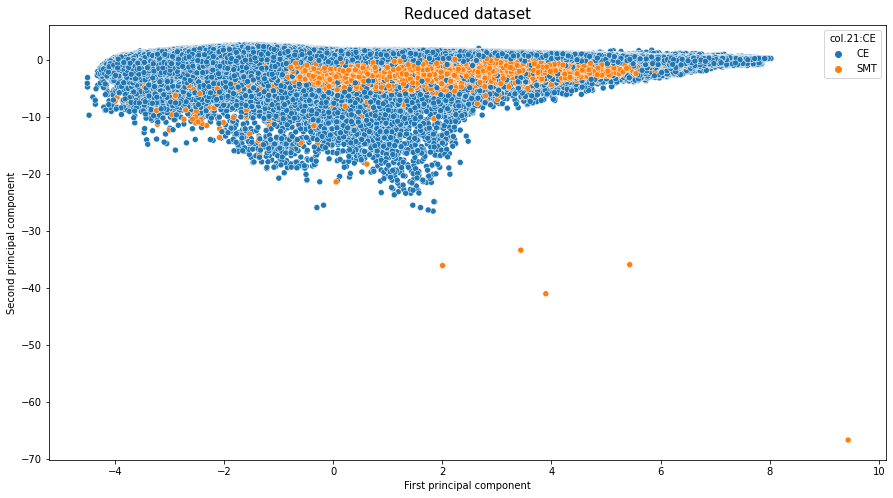

In [30]:
# Data in the PCA basis
data_ = np.dot(X_train_full_, V)

# Reduce the dimensionality of the dataset 
data_reduced = data_[:,:ncomp]

X_train_PCA_full = pd.DataFrame(data_reduced)
X_test_PCA_full = pd.DataFrame(np.dot(X_test_full_, V)[:,:ncomp])
print(X_train_PCA_full.shape)
print(X_test_PCA_full.shape)

df = pd.DataFrame(np.column_stack((X_train_PCA_full, Y_train_full)))
df.rename(columns = {ncomp:'col.21:CE'}, inplace=True)
display(df.head())

plt.figure(figsize=(15, 8))
sns.scatterplot(x=0, y=1, hue='col.21:CE', data=df)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Reduced dataset', fontsize=15)
plt.show()

### Random Forest: Full dataset with smoothing, no normalization of data

In [31]:
best_param = {'max_depth':7, 'min_samples_leaf':1e-04}
smooth_RF_full_clf = RandomForestClassifier(max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf'])
smooth_RF_full_clf.fit(X_train_full, Y_train_full)

train_err = 1 - smooth_RF_full_clf.score(X_train_full, Y_train_full)
print("Training error = %1.5f" % train_err)

test_err = 1 - smooth_RF_full_clf.score(X_test_full, Y_test_full)
print("Test error = %1.5f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([smooth_RF_full_clf.feature_names_in_, smooth_RF_full_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.00914
Test error = 0.00904


,feature names,feature importance
9,colExt1:ratio_m1_m2_ZAMS,0.25073
10,colExt2:ratio_m1_m2_rem,0.165202
5,col.7:sma/Rsun,0.152322
0,col.1:m1ZAMS/Msun,0.115452
2,col.3:m1rem/Msun,0.097236
1,col.2:m2ZAMS/Msun,0.070887
3,col.4:m2rem/Msun,0.052864
6,col.8:ecc,0.050878
4,col.6:delay_time/Myr,0.02413
7,metallicity,0.011495


In [32]:
# Export as dot file
#export_graphviz(smooth_RF_full_clf.estimators_[50], out_file='smooth_RF_full.dot', 
#                feature_names = smooth_RF_full_clf.feature_names_in_,
#                class_names = smooth_RF_full_clf.classes_,
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

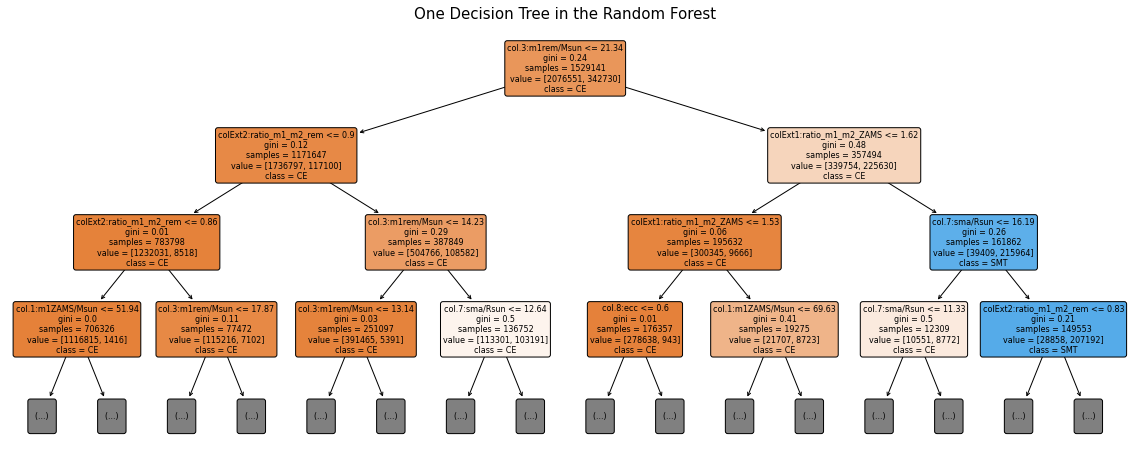

In [33]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(smooth_RF_full_clf.estimators_[50], max_depth=3,
                        feature_names = smooth_RF_full_clf.feature_names_in_,
                        class_names = smooth_RF_full_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize=8, ax=ax)

ax.set_title('One Decision Tree in the Random Forest', fontsize=15)
plt.show()

### Random Forest: Full dataset with smoothing, with PCA

In [ ]:
best_param = {'max_depth':7, 'min_samples_leaf':1e-04}
smooth_RF_PCA_full_clf = RandomForestClassifier(max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf'])
smooth_RF_PCA_full_clf.fit(X_train_PCA_full, Y_train_full)

train_err = 1 - smooth_RF_PCA_full_clf.score(X_train_PCA_full, Y_train_full)
print("Training error = %1.3f" % train_err)

test_err = 1 - smooth_RF_PCA_full_clf.score(X_test_PCA_full, Y_test_full)
print("Test error = %1.3f" % test_err)

In [ ]:
# Export as dot file
#export_graphviz(smooth_RF_full_clf.estimators_[50], out_file='smooth_RF_PCA_full.dot', 
#                feature_names = smooth_RF_PCA_full_clf.feature_names_in_,
#                class_names = smooth_RF_PCA_full_clf.classes_,
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

### SVM: reduced dataset, with normalization of data

In [ ]:
SVM_clf = sklearn.svm.SVC(kernel='linear')
SVM_clf.fit(X_train_, Y_train)

train_err = 1 - SVM_clf.score(X_train_, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - SVM_clf.score(X_test_, Y_test)
print("Test error = %1.3f" % test_err)

display(pd.DataFrame(data=np.array([SVM_clf.feature_names_in_, np.abs(SVM_clf.coef_[0])]).T,
                     columns=["feature names", "feature weights (absolute value)"]).sort_values(by="feature weights (absolute value)", ascending=False))

### SVM: full dataset, with normalization of data

In [ ]:
SVM_full_clf = sklearn.svm.LinearSVC(dual=False)
SVM_full_clf.fit(X_train_full_, Y_train_full)

train_err = 1 - SVM_full_clf.score(X_train_full_, Y_train_full)
print("Training error = %1.5f" % train_err)
test_err = 1 - SVM_full_clf.score(X_test_full_, Y_test_full)
print("Test error = %1.5f" % test_err)

display(pd.DataFrame(data=np.array([SVM_full_clf.feature_names_in_, np.abs(SVM_full_clf.coef_[0])]).T,
                     columns=["feature names", "feature weights (absolute value)"]).sort_values(by="feature weights (absolute value)", ascending=False))

### SVM: full dataset, with PCA

In [ ]:
SVM_PCA_full_clf = sklearn.svm.LinearSVC(dual=False)
SVM_PCA_full_clf.fit(X_train_PCA_full, Y_train_full)

train_err = 1 - SVM_PCA_full_clf.score(X_train_PCA_full, Y_train_full)
print("Training error = %1.5f" % train_err)
test_err = 1 - SVM_PCA_full_clf.score(X_test_PCA_full, Y_test_full)
print("Test error = %1.5f" % test_err)

## Graphs
### Initial and final masses of the members

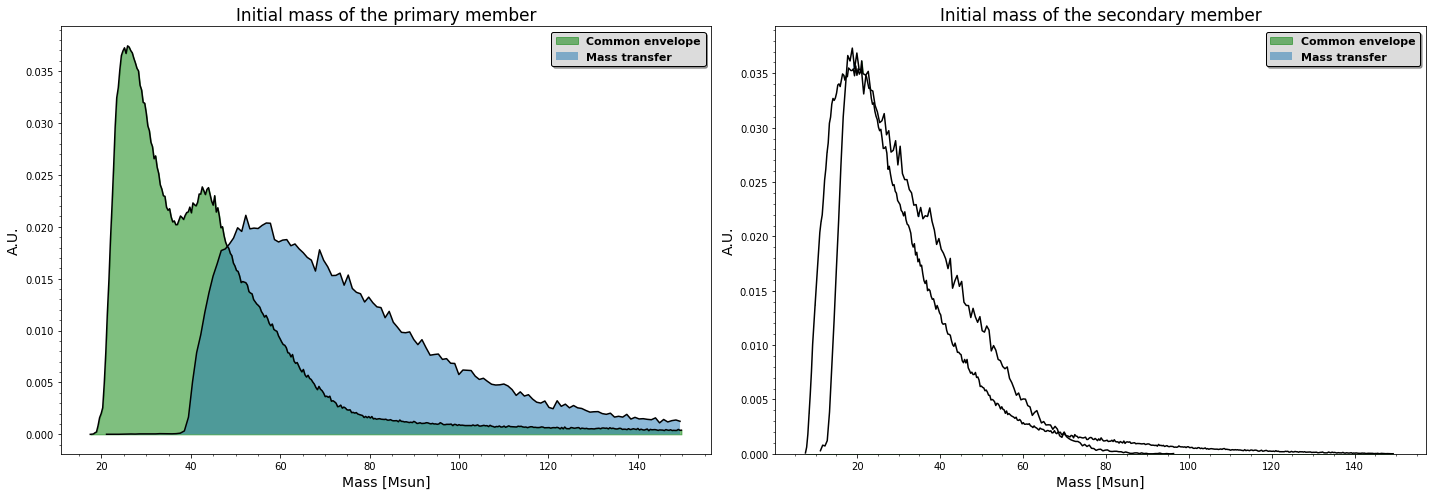

In [35]:
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(20, 7))



#[0]  -   col.1:m1ZAMS/Msun - col.21:CE   - Initial mass of the primary member per Formation Process

entries_1_t, edges_1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.1:m1ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_1_t = 0.5 * (edges_1_t[:-1] + edges_1_t[1:])       #Norm Hist for TRUE - CommonEnvelope  

entries_1_f, edges_1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.1:m1ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_1_f = 0.5 * (edges_1_f[:-1] + edges_1_f[1:])       #Norm Hist for FALSE - StableMassTransfer

ax[0].plot(bin_centers_1_t, entries_1_t, color='black')
ax[0].fill_between(bin_centers_1_t, entries_1_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0].plot(bin_centers_1_f, entries_1_f, color='black')
ax[0].fill_between(bin_centers_1_f, entries_1_f, alpha=0.5, label = 'Mass transfer')

ax[0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0].set_title('Initial mass of the primary member', fontsize=17)
ax[0].set_xlabel('Mass [Msun]', fontsize=14)
ax[0].set_ylabel('A.U.', fontsize=14)                 #legend & titles
ax[0].minorticks_on()




#[1]  -   col.2:m2ZAMS/Msun - col.21:CE   - Initial mass of the secondary member per Formation Process

entries_2_t, edges_2_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.2:m2ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_2_t = 0.5 * (edges_2_t[:-1] + edges_2_t[1:])      # Norm Hist for TRUE - CommonEnvelope 

entries_2_f, edges_2_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.2:m2ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_2_f = 0.5 * (edges_2_f[:-1] + edges_2_f[1:])      #Norm Hist for FALSE - StableMassTransfer

ax[1].plot(bin_centers_2_t, entries_2_t, color='black')
ax[1].fill_between(bin_centers_2_t, entries_2_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1].plot(bin_centers_2_f, entries_2_f, color='black')
ax[1].fill_between(bin_centers_2_f, entries_2_f, alpha=0.5, label = 'Mass transfer')

ax[1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1].set_title('Initial mass of the secondary member', fontsize=17)
ax[1].set_xlabel('Mass [Msun]', fontsize=14)
ax[1].set_ylabel('A.U.', fontsize=14)             #legend & titles
ax[1].minorticks_on()



fig.tight_layout()

- In the left plot the two formation processes are carachterized by two different ranges of mass values: increasing the initial mass of the primary member the Stable Mass Transfer process is predominant with respect to the CE. 

- Concerning the initial mass of the secondary member (right plot) instead there are no region of mass values related to a predominance of one of the two formation processes. 

These plots agree with the results found by the Random Forest algorithm, in fact the initial mass of the primary member is more and more relevant in the classification task than the mass of the secondary member.


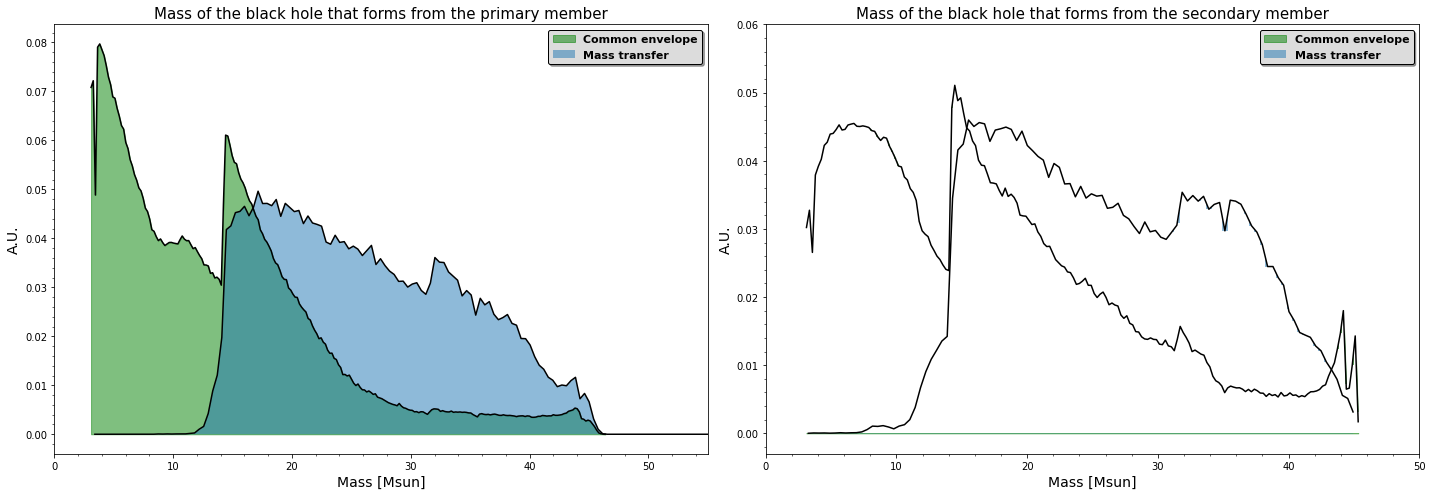

In [36]:
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(20, 7))


#[0]  -   col.3:m1rem/Msun - col.21:CE   - BlackHole mass from the primary member per Formation Process

entries_3_t, edges_3_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.3:m1rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_3_t = 0.5 * (edges_3_t[:-1] + edges_3_t[1:])    #Norm Hist for TRUE - CommonEnvelope

entries_3_f, edges_3_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.3:m1rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_3_f = 0.5 * (edges_3_f[:-1] + edges_3_f[1:])    #Norm Hist for FALSE - StableMassTransfer

ax[0].plot(bin_centers_3_t, entries_3_t, color='black')
ax[0].fill_between(bin_centers_3_t, entries_3_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0].plot(bin_centers_3_f, entries_3_f, color='black')
ax[0].fill_between(bin_centers_3_f, entries_3_f, alpha=0.5, label = 'Mass transfer')

ax[0].set_xlim(right=55, left= 0)
ax[0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0].set_title('Mass of the black hole that forms from the primary member', fontsize=15)
ax[0].set_xlabel('Mass [Msun]', fontsize=14)
ax[0].set_ylabel('A.U.', fontsize=14)           #legend & titles
ax[0].minorticks_on()


#[1]  -   col.4:m2rem/Msun - col.21:CE   - BlackHole mass from the secondary member per Formation Process


entries_4_t, edges_4_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.4:m2rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_4_t = 0.5 * (edges_4_t[:-1] + edges_4_t[1:])          #Norm Hist for TRUE - CommonEnvelope

entries_4_f, edges_4_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.4:m2rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_4_f = 0.5 * (edges_4_f[:-1] + edges_4_f[1:])          #Norm Hist for FALSE - StableMassTransfer

ax[1].plot(bin_centers_4_t, entries_4_t, color='black')
ax[1].fill_between(bin_centers_4_t, entries_4_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1].plot(bin_centers_4_f, entries_4_f, color='black')
ax[1].fill_between(bin_centers_4_f, entries_4_f, alpha=0.5, label = 'Mass transfer')

ax[1].set_xlim(right=50, left= 0)
ax[1].set_ylim(bottom=-0.003, top=0.06)
ax[1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1].set_title('Mass of the black hole that forms from the secondary member', fontsize=15)
ax[1].set_xlabel('Mass [Msun]', fontsize=14)
ax[1].set_ylabel('A.U.', fontsize=14)                #legend & titles
ax[1].minorticks_on()  



fig.tight_layout()

These two graphs show a similar behaviour regarding the formation processes and the mass of the black hole originated by the primary (on the left) and the secondary (on the right) members. 

For both observables in fact there are not specific regions of values carachterized by a clear separation within one of the two formation processes. 


### Time elapsed, eccentricity, sma

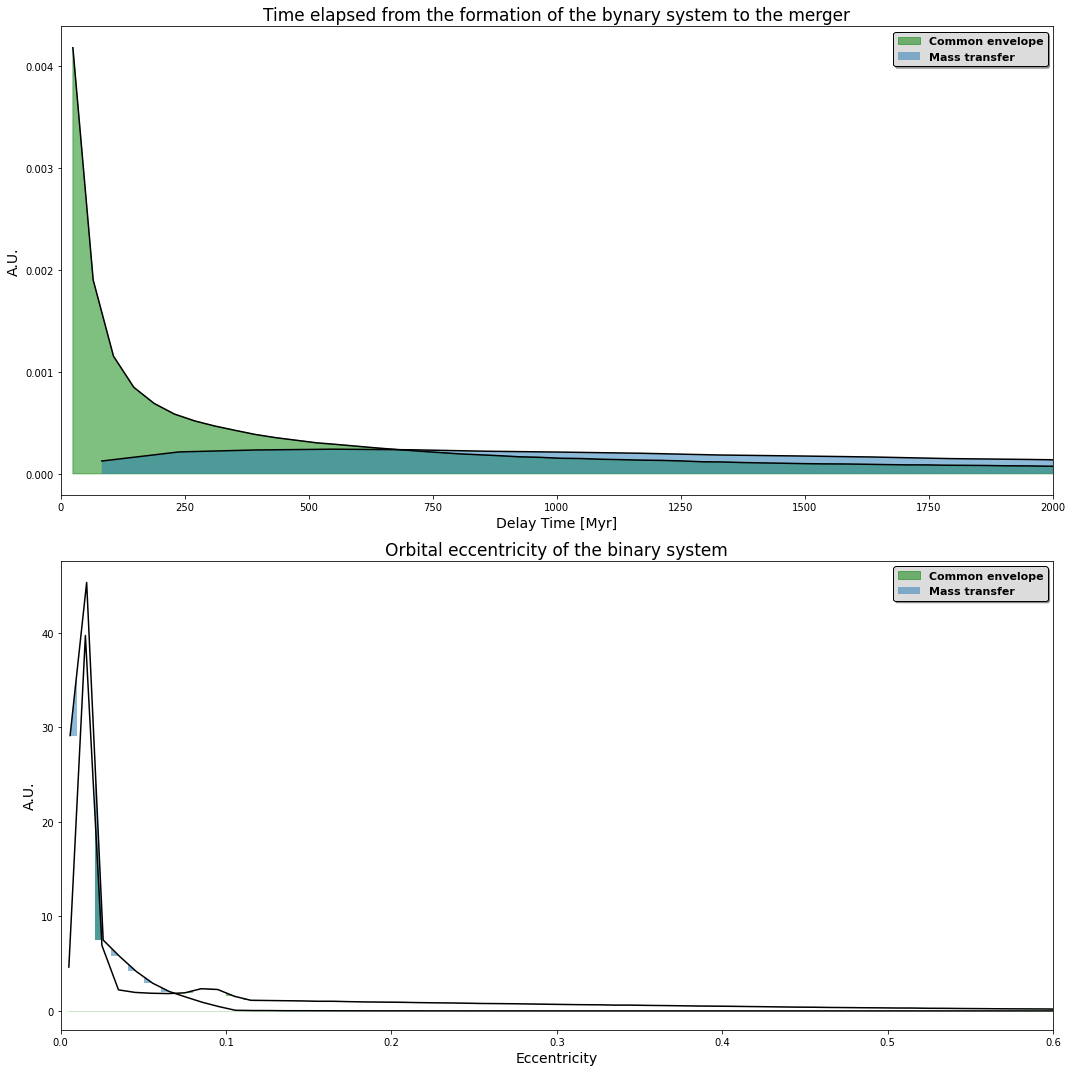

In [37]:
fig, ax = plt.subplots(nrows= 2, ncols=1, figsize=(15, 15))



#[0]  -   col.6:delay_time/Myr - col.21:CE   - Delay Time per Formation Process

entries_dt_t, edges_dt_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.6:delay_time/Myr'], bins = 'fd', color = 'w', density=True)
bin_centers_dt_t = 0.5 * (edges_dt_t[:-1] + edges_dt_t[1:])       #Norm Hist for TRUE - CommonEnvelope  

entries_dt_f, edges_dt_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.6:delay_time/Myr'], bins = 'fd', color = 'w', density=True)
bin_centers_dt_f = 0.5 * (edges_dt_f[:-1] + edges_dt_f[1:])       #Norm Hist for FALSE - StableMassTransfer

ax[0].plot(bin_centers_dt_t, entries_dt_t, color='black')
ax[0].fill_between(bin_centers_dt_t, entries_dt_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0].plot(bin_centers_dt_f, entries_dt_f, color='black')
ax[0].fill_between(bin_centers_dt_f, entries_dt_f, alpha=0.5, label = 'Mass transfer')


ax[0].set_xlim(right=2000, left= 0)
ax[0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0].set_title('Time elapsed from the formation of the bynary system to the merger', fontsize=17)
ax[0].set_xlabel('Delay Time [Myr]', fontsize=14)
ax[0].set_ylabel('A.U.', fontsize=14)                 #legend & titles




#[1]  -   col.8:ecc - col.21:CE   - Orbital eccentricity of the binary system vs Formation Process

entries_ecc_t, edges_ecc_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.8:ecc'], bins = 100, color = 'w', density=True)
bin_centers_ecc_t = 0.5 * (edges_ecc_t[:-1] + edges_ecc_t[1:])      # Norm Hist for TRUE - CommonEnvelope 

entries_ecc_f, edges_ecc_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.8:ecc'], bins = 100, color = 'w', density=True)
bin_centers_ecc_f = 0.5 * (edges_ecc_f[:-1] + edges_ecc_f[1:])      #Norm Hist for FALSE - StableMassTransfer

ax[1].plot(bin_centers_ecc_t, entries_ecc_t, color='black')
ax[1].fill_between(bin_centers_ecc_t, entries_ecc_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1].plot(bin_centers_ecc_f, entries_ecc_f, color='black')
ax[1].fill_between(bin_centers_ecc_f, entries_ecc_f, alpha=0.5, label = 'Mass transfer')


ax[1].set_xlim(right=0.6, left=0)
ax[1].set_ylim(bottom=-2)
ax[1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1].set_title('Orbital eccentricity of the binary system', fontsize=17)
ax[1].set_xlabel('Eccentricity', fontsize=14)
ax[1].set_ylabel('A.U.', fontsize=14)             #legend & titles


fig.tight_layout()

- The first plot shows the relation between the formation process and the time elapsed from the formation of the bynary system to the merger of the two black holes: for most of values of this parameter there is a similar correlation with the two formation processes.

As in the Random Forest results, this feature almost has no impact in the binary black hole evolution. 


- The second plot represents the relation between the orbital eccentricity of the binary system and the formation process. For all the measured values of this parameter there is not a predominance for one process over the other.

In agreement with the results of the machine learning algorithm this feature is not useful to our classification task.  


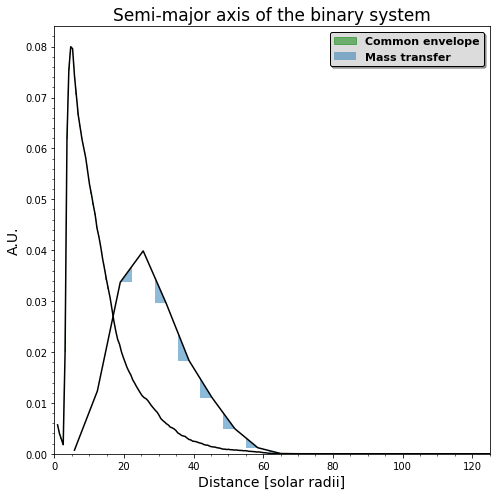

In [38]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(7, 7))

entries_1_t, edges_1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.7:sma/Rsun'], bins = 50000, color = 'w', density=True)
bin_centers_1_t = 0.5 * (edges_1_t[:-1] + edges_1_t[1:])

entries_1_f, edges_1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.7:sma/Rsun'], bins = 50000, color = 'w', density=True)
bin_centers_1_f = 0.5 * (edges_1_f[:-1] + edges_1_f[1:])

ax.plot(bin_centers_1_t, entries_1_t, color='black')
ax.fill_between(bin_centers_1_t, entries_1_t, alpha=0.5, color='green', label = 'Common envelope')

ax.plot(bin_centers_1_f, entries_1_f, color='black')
ax.fill_between(bin_centers_1_f, entries_1_f, alpha=0.5, label = 'Mass transfer')

ax.legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax.set_title('Semi-major axis of the binary system', fontsize=17)
ax.set_xlabel('Distance [solar radii]', fontsize=14)
ax.set_ylabel('A.U.', fontsize=14)
ax.set_xlim(left=0, right=125)
ax.minorticks_on()


fig.tight_layout()

From this plot we can see that the semi-major axis of the binary system at the formation of the second-born black hole is different between the two formation processes also with an almost clear separation between the two cases. Indeed, the value of this parameter is smaller when the system undergoes a Common Envelope with respect to when it evolves via Stable Mass Transfer.

We believe that this difference is related to the Common Envelope process, during which the two members of the binary system reduce their mutual distance by spiraling in the gaseous environment. 
As an effect of the spiral in, after the CE we expect an orbital separation of the two objects much smaller than the initial one.

This separation is also useful for the Random Forest algorithm, in the sense that is a good discriminant for splitting and analyzing the data.

### Mass ratio

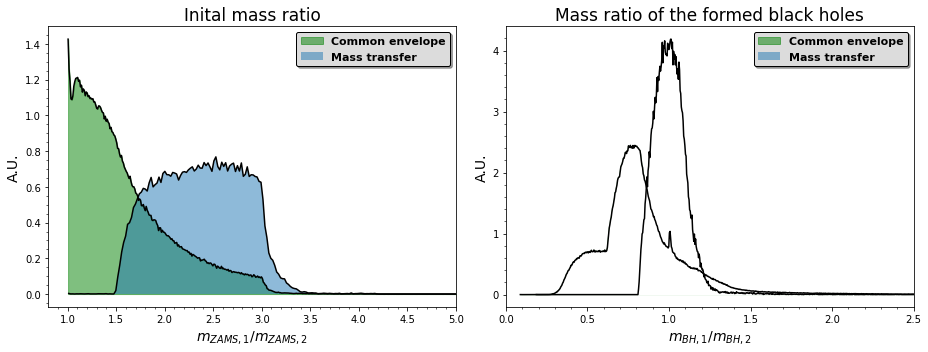

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))



#[0]  -   col.1:m1ZAMS/Msun - col.21:CE   - Initial mass of the primary member per Formation Process

entries_ex1_t, edges_ex1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['colExt1:ratio_m1_m2_ZAMS'], bins = 'fd', color = 'w', density=True)
bin_centers_ex1_t = 0.5 * (edges_ex1_t[:-1] + edges_ex1_t[1:])       #Norm Hist for TRUE - CommonEnvelope  

entries_ex1_f, edges_ex1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['colExt1:ratio_m1_m2_ZAMS'], bins = 'fd', color = 'w', density=True)
bin_centers_ex1_f = 0.5 * (edges_ex1_f[:-1] + edges_ex1_f[1:])       #Norm Hist for FALSE - StableMassTransfer

ax[0].plot(bin_centers_ex1_t, entries_ex1_t, color='black')
ax[0].fill_between(bin_centers_ex1_t, entries_ex1_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0].plot(bin_centers_ex1_f, entries_ex1_f, color='black')
ax[0].fill_between(bin_centers_ex1_f, entries_ex1_f, alpha=0.5, label = 'Mass transfer')

ax[0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0].set_title('Inital mass ratio', fontsize=17)
ax[0].set_xlabel(r'$m_{ZAMS, 1}/m_{ZAMS, 2}$', fontsize=14)
ax[0].set_ylabel('A.U.', fontsize=14)                 #legend & titles

ax[0].set_xlim(left=0.8,right=5)
ax[0].minorticks_on()


#[1]  -   col.2:m2ZAMS/Msun - col.21:CE   - Initial mass of the secondary member per Formation Process

entries_ex2_t, edges_ex2_t, _ = plt.hist(frame[frame['col.21:CE']==True]['colExt2:ratio_m1_m2_rem'], bins = 'fd', color = 'w', density=True)
bin_centers_ex2_t = 0.5 * (edges_ex2_t[:-1] + edges_ex2_t[1:])      # Norm Hist for TRUE - CommonEnvelope 

entries_ex2_f, edges_ex2_f, _ = plt.hist(frame[frame['col.21:CE']==False]['colExt2:ratio_m1_m2_rem'], bins = 'fd', color = 'w', density=True)
bin_centers_ex2_f = 0.5 * (edges_ex2_f[:-1] + edges_ex2_f[1:])      #Norm Hist for FALSE - StableMassTransfer

ax[1].plot(bin_centers_ex2_t, entries_ex2_t, color='black')
ax[1].fill_between(bin_centers_ex2_t, entries_ex2_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1].plot(bin_centers_ex2_f, entries_ex2_f, color='black')
ax[1].fill_between(bin_centers_ex2_f, entries_ex2_f, alpha=0.5, label = 'Mass transfer')

ax[1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1].set_title('Mass ratio of the formed black holes', fontsize=17)
ax[1].set_xlabel(r'$m_{BH, 1}/m_{BH, 2}$', fontsize=14)
ax[1].set_ylabel('A.U.', fontsize=14)             #legend & titles

ax[1].set_xlim(left=0,right=2.5)
ax[1].set_ylim(bottom=-0.2)
ax[1].minorticks_on()

fig.tight_layout()


The mass ratio of the two bodies, both at the ZAMS and at the end, after the formation of the BHs, represent the most relevant feature for the Random Forest algorithm used to classify the data according to the BBH formation process. The two graphs represent:
- On the left: the ratio between the initial masses of the primary and the secondary member. Clearly this ratio is bigger than 1 because in the formation of a BBH $ \  \ m_{ZAMS, 1}\  \ > m_{ZAMS, 2} \ \ $.
- On the right: the ratio between the mass of the Black Hole that originates from the primary member and the one that forms from the secondary member. This ratio, due to the mass transfer happening during the two processes, can be smaller than one.

In both plots there is a similar behaviour: there are regions of mass ratios related to a predominance of one formation process over the other.
In fact, especially in the left plot, for an increasing value of the ratio between the two initial masses, the "absolute preference" for the Common Envelope process decreases in favor of the Stable mass transfer.


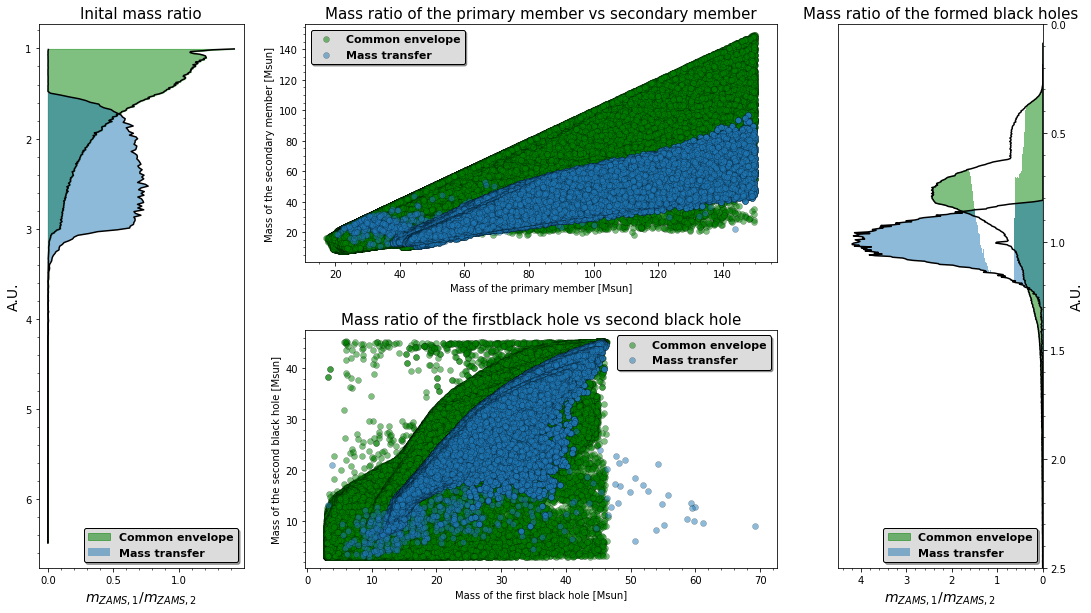

In [40]:
# Visualizing the masses
plt.figure(figsize = (18, 10))
grid = plt.GridSpec(4, 4, wspace =0.3, hspace = 0.8)


g1 = plt.subplot(grid[:, 0])
g2 = plt.subplot(grid[:2, 1:3])
g3 = plt.subplot(grid[2:, 1:3])
g4 = plt.subplot(grid[:, 3])


entries_g1_t, edges_g1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['colExt1:ratio_m1_m2_ZAMS'], bins = 'fd', color = 'w', density=True)
bin_centers_g1_t = 0.5 * (edges_g1_t[:-1] + edges_g1_t[1:])       #Norm Hist for TRUE - CommonEnvelope  
entries_g1_f, edges_g1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['colExt1:ratio_m1_m2_ZAMS'], bins = 'fd', color = 'w', density=True)
bin_centers_g1_f = 0.5 * (edges_g1_f[:-1] + edges_g1_f[1:])       #Norm Hist for FALSE - StableMassTransfer



g1.plot(entries_g1_t, bin_centers_g1_t,   color='black')
g1.fill_betweenx(bin_centers_g1_t, entries_g1_t, x2=0, color='green', alpha=0.5, label = 'Common envelope')

g1.plot(entries_g1_f, bin_centers_g1_f,   color='black')
g1.fill_betweenx(bin_centers_g1_f, entries_g1_f, x2=0, alpha=0.5, label = 'Mass transfer')


g1.legend(prop={'weight':'bold','size':11}, loc='lower right', facecolor='gainsboro', edgecolor='black', shadow=True)
g1.set_title('Inital mass ratio', fontsize=15)
g1.set_xlabel(r'$m_{ZAMS, 1}/m_{ZAMS, 2}$', fontsize=14)
g1.set_ylabel('A.U.', fontsize=14)                 #legend & titles
g1.invert_yaxis()



g1.minorticks_on()





entries_g4_t, edges_g4_t, _ = plt.hist(frame[frame['col.21:CE']==True]['colExt2:ratio_m1_m2_rem'], bins = 'fd', color = 'w', density=True)
bin_centers_g4_t = 0.5 * (edges_g4_t[:-1] + edges_g4_t[1:])       #Norm Hist for TRUE - CommonEnvelope

entries_g4_f, edges_g4_f, _ = plt.hist(frame[frame['col.21:CE']==False]['colExt2:ratio_m1_m2_rem'], bins = 'fd', color = 'w', density=True)
bin_centers_g4_f = 0.5 * (edges_g4_f[:-1] + edges_g4_f[1:])       #Norm Hist for FALSE - StableMassTransfer



g4.plot(entries_g4_t, bin_centers_g4_t,   color='black')
g4.fill_betweenx(bin_centers_g4_t, entries_g4_t, x2=0, color='green', alpha=0.5, label = 'Common envelope')

g4.plot(entries_g4_f, bin_centers_g4_f,   color='black')
g4.fill_betweenx(bin_centers_g4_f, entries_g4_f, x2=0, alpha=0.5, label = 'Mass transfer')


g4.legend(prop={'weight':'bold','size':11}, loc='lower right', facecolor='gainsboro', edgecolor='black', shadow=True)
g4.set_title('Mass ratio of the formed black holes', fontsize=15)
g4.set_xlabel(r'$m_{ZAMS, 1}/m_{ZAMS, 2}$', fontsize=14)
g4.set_ylabel('A.U.', fontsize=14)                 #legend & titles
g4.invert_yaxis()
g4.set_ylim(top = 0, bottom=2.5)
g4.set_xlim(left = 0, right=4.5)
g4.invert_xaxis()
g4.yaxis.tick_right()
g4.yaxis.set_label_position("right")


g4.minorticks_on()




g2.scatter(x=frame[frame['col.21:CE']==True]['col.1:m1ZAMS/Msun'], y=frame[frame['col.21:CE']==True]['col.2:m2ZAMS/Msun'], alpha=0.5, edgecolor='black', color='green', linewidth=0.3, label='Common envelope')
g2.scatter(x=frame[frame['col.21:CE']==False]['col.1:m1ZAMS/Msun'], y=frame[frame['col.21:CE']==False]['col.2:m2ZAMS/Msun'], alpha=0.5, edgecolor='black', linewidth=0.3, label='Mass transfer')

g2.set_xlabel('Mass of the primary member [Msun]')
g2.set_ylabel('Mass of the secondary member [Msun]')
g2.legend(prop={'weight':'bold','size':11}, loc='best', facecolor='gainsboro', edgecolor='black', shadow=True)
g2.set_title('Mass ratio of the primary member vs secondary member', fontsize=15)
g2.minorticks_on()

g3.scatter(x=frame[frame['col.21:CE']==True]['col.3:m1rem/Msun'], y=frame[frame['col.21:CE']==True]['col.4:m2rem/Msun'], alpha=0.5,  edgecolor='black', color='green', linewidth=0.3, label='Common envelope')
g3.scatter(x=frame[frame['col.21:CE']==False]['col.3:m1rem/Msun'], y=frame[frame['col.21:CE']==False]['col.4:m2rem/Msun'], alpha=0.5, edgecolor='black', linewidth=0.3, label='Mass transfer')

g3.set_xlabel('Mass of the first black hole [Msun]')
g3.set_ylabel('Mass of the second black hole [Msun]')
g3.legend(prop={'weight':'bold','size':11}, loc='best', facecolor='gainsboro', edgecolor='black', shadow=True)
g3.set_title('Mass ratio of the firstblack hole vs second black hole', fontsize=15)
g3.minorticks_on()

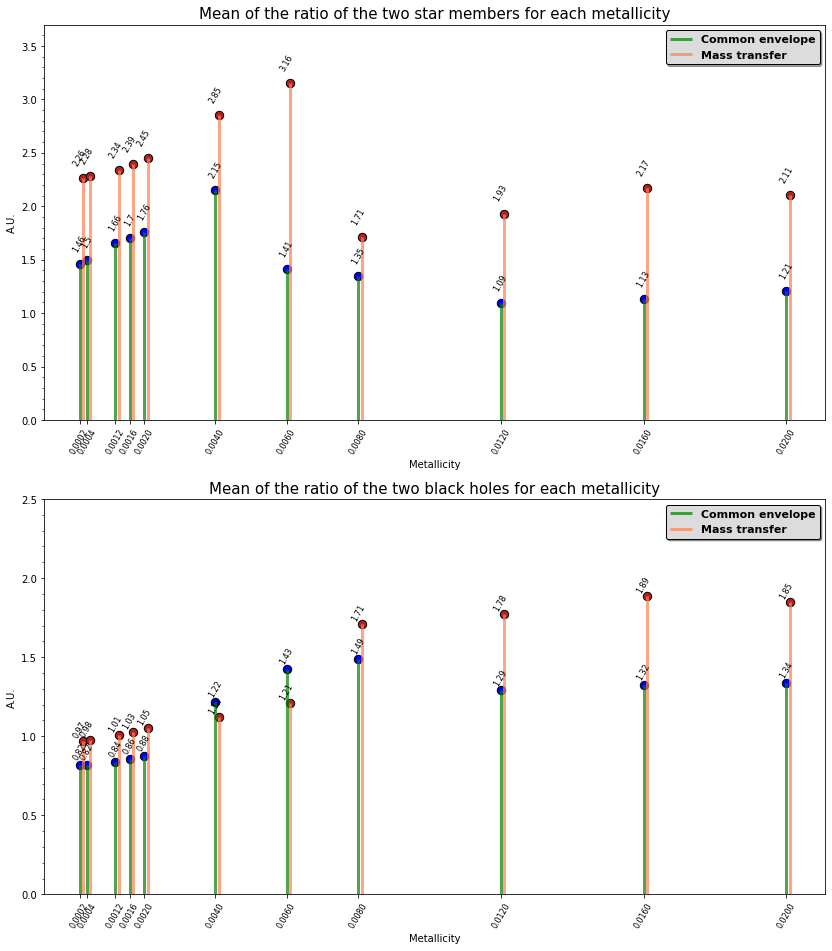

In [44]:
# Looking for the caveat...

frame_met_g1 = frame[frame['col.21:CE']==True].groupby('metallicity')['colExt1:ratio_m1_m2_ZAMS'].agg([np.mean])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 16))
ax[0].vlines(x=np.sort(frame['metallicity'].unique()), ymin=0, ymax = frame_met_g1['mean'],
        color = 'green', alpha = 0.7, linewidth = 3, label='Common envelope')

ax[0].scatter(x = np.sort(frame['metallicity'].unique()), y = frame_met_g1['mean'], s = 70, color = "blue", edgecolor='black')
for row in frame_met_g1.itertuples():
    ax[0].text(row.Index, row.mean+0.1, s = round(row.mean,2),
           horizontalalignment = 'center', verticalalignment='bottom', fontsize=8, rotation=60)           

    
frame_met_g2 = frame[frame['col.21:CE']==False].groupby('metallicity')['colExt1:ratio_m1_m2_ZAMS'].agg([np.mean])
ax[0].vlines(x=np.sort(frame['metallicity'].unique())+0.0001, ymin=0, ymax = frame_met_g2['mean'],
        color = 'coral', alpha = 0.7, linewidth = 3, label='Mass transfer')
ax[0].scatter(x = np.sort(frame['metallicity'].unique())+0.0001, y = frame_met_g2['mean'], s = 70, color = "firebrick", edgecolor='black')

ax[0].set_xticks(frame['metallicity'].unique())
ax[0].tick_params(axis='x', which='major', labelsize=8, rotation=60)
ax[0].minorticks_on()
ax[0].legend(prop={'weight':'bold','size':11}, loc='best', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0].set_xlabel('Metallicity')
ax[0].set_ylabel('A.U.')
ax[0].set_title('Mean of the ratio of the two star members for each metallicity', fontsize=15)
ax[0].set_ylim(top=3.7, bottom=0)
for row in frame_met_g2.itertuples():
    ax[0].text(row.Index, row.mean+0.1, s = round(row.mean,2),
           horizontalalignment = 'center', verticalalignment='bottom', fontsize=8, rotation=60)           



frame_met_g1 = frame[frame['col.21:CE']==True].groupby('metallicity')['colExt2:ratio_m1_m2_rem'].agg([np.mean])



ax[1].vlines(x=np.sort(frame['metallicity'].unique()), ymin=0, ymax = frame_met_g1['mean'],
        color = 'green', alpha = 0.7, linewidth = 3, label='Common envelope')
ax[1].scatter(x = np.sort(frame['metallicity'].unique()), y = frame_met_g1['mean'], s = 70, color = "blue", edgecolor='black')
for row in frame_met_g1.itertuples():
    ax[1].text(row.Index, row.mean+0.02, s = round(row.mean,2),
           horizontalalignment = 'center', verticalalignment='bottom', fontsize=8, rotation=60)          

    
frame_met_g2 = frame[frame['col.21:CE']==False].groupby('metallicity')['colExt2:ratio_m1_m2_rem'].agg([np.mean])
ax[1].vlines(x=np.sort(frame['metallicity'].unique())+0.0001, ymin=0, ymax = frame_met_g2['mean'],
        color = 'coral', alpha = 0.7, linewidth = 3, label='Mass transfer')
ax[1].scatter(x = np.sort(frame['metallicity'].unique())+0.0001, y = frame_met_g2['mean'], s = 70, color = "firebrick", edgecolor='black')

ax[1].set_xticks(frame['metallicity'].unique())
ax[1].tick_params(axis='x', which='major', labelsize=8, rotation=60)
ax[1].minorticks_on()
ax[1].legend(prop={'weight':'bold','size':11}, loc='best', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1].set_xlabel('Metallicity')
ax[1].set_ylabel('A.U.')
ax[1].set_title('Mean of the ratio of the two black holes for each metallicity', fontsize=15)
ax[1].set_ylim(top=2.5, bottom=0)
for row in frame_met_g2.itertuples():
    ax[1].text(row.Index, row.mean+0.01, s = round(row.mean,2),
           horizontalalignment = 'center', verticalalignment='bottom', fontsize=8, rotation=60)          

